In [1]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import csv
import seaborn as sns

Generate dataset

In [2]:
def generate_dataset(num_samples, num_outliers):
    # Generate random samples
    samples = np.random.rand(num_samples, 3)

    # Generate random indices for outliers
    outlier_indices = np.random.choice(num_samples, num_outliers, replace=False)

    # Assign labels to samples
    labels = np.zeros(num_samples)
    labels[outlier_indices] = 1

    return samples, labels

num_samples = 90
num_outliers = 10

dataset, labels = generate_dataset(num_samples, num_outliers)

In [3]:
labels

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], requires_grad=True)

In [4]:
normal_data = []
anomalies = []

for i in range(len(dataset)):
    if(labels[i] == 0.):
        normal_data.append(dataset[i])
    else:
        anomalies.append(dataset[i])

In [5]:
n_qubits = 3
n_layers_g = 3
n_layers_d = 3

In [6]:
startval_gpar = (2.*np.pi)*np.random.random(n_qubits*n_layers_g)
startval_dpar = (2.*np.pi)*np.random.random(3*n_qubits*n_layers_d+3)

In [7]:
gen_dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(gen_dev)
def generator_discriminator(g_par, d_par):
    """Generator and discriminator circuits.

    Args:
        g_par (array): array of parameters for the generator
        d_par (array): array of parameters for the discriminator

    Returns:
        expectation value of the Pauli Z on the last qubit
    """
    # Generator circuit
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    shape = (n_layers_g, n_qubits)
    g_par = g_par.reshape(shape)
    for j in range(n_layers_g):
        for i in range(n_qubits):
            qml.RY(g_par[j,i], wires=i)
        # There must be a better way to do this
        qml.CZ(wires=[0,1])
        qml.CZ(wires=[1,2])
        qml.CZ(wires=[0,2])

    # Discriminator circuit
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    
    layer_par = d_par[:3*n_qubits*n_layers_d]
    shape = (n_layers_d, n_qubits, 3)
    layer_par = layer_par.reshape(shape)
    for j in range(n_layers_d):
        for i in range(n_qubits):
            qml.Rot(layer_par[j,i,0], layer_par[j,i,1], layer_par[j,i,2], wires=i)
        qml.CZ(wires=[0,1])
        qml.CZ(wires=[1,2])

    qml.CNOT(wires=[0,2])
    qml.CNOT(wires=[0,1])
    last_layer_par = d_par[3*n_qubits*n_layers_d:]
    qml.Rot(last_layer_par[0], last_layer_par[1], last_layer_par[2], wires=2)

    return qml.expval(qml.PauliZ(wires=n_qubits-1))

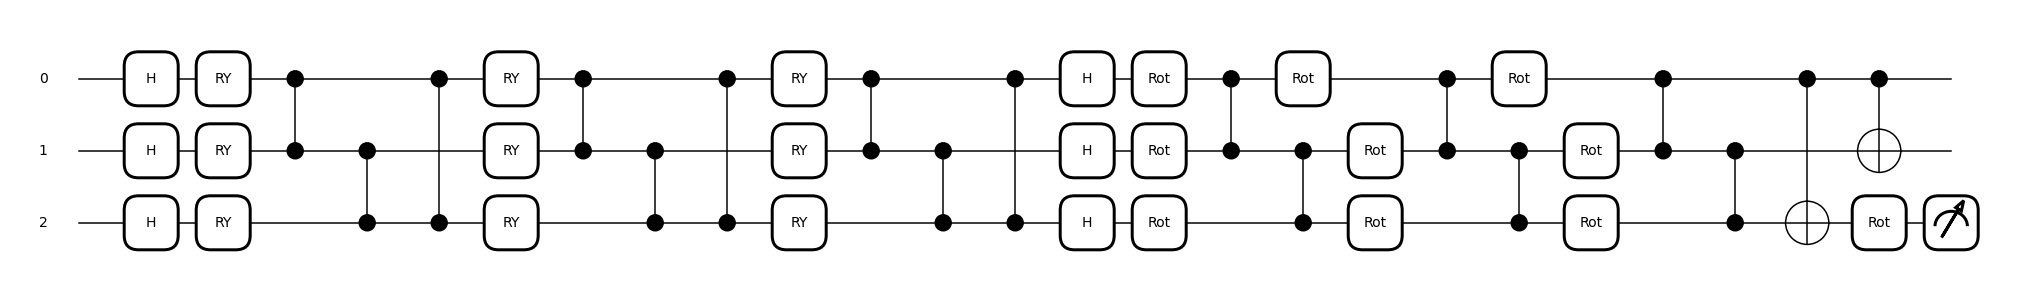

In [8]:
%%capture --no-display
drawer = qml.draw_mpl(generator_discriminator)
print(drawer(startval_gpar, startval_dpar))

In [9]:
enc_dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(enc_dev)
def encoding_discriminator(sample, d_par):
    """Encoding and discriminator circuits.

    Args:
        sample (array): array of parameters for a single data point in training dataset
        d_par (array): array of parameters for the discriminator

    Returns:
        expectation value of the Pauli Z on the last qubit
    """
    # Encoding circuit
    for i in range(n_qubits):
        qml.RY(sample[i], wires=i)

    # Discriminator circuit
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    
    layer_par = d_par[:3*n_qubits*n_layers_d]
    shape = (n_layers_d, n_qubits, 3)
    layer_par = layer_par.reshape(shape)
    for j in range(n_layers_d):
        for i in range(n_qubits):
            qml.Rot(layer_par[j,i,0], layer_par[j,i,1], layer_par[j,i,2], wires=i)
        qml.CZ(wires=[0,1])
        qml.CZ(wires=[1,2])

    qml.CNOT(wires=[0,2])
    qml.CNOT(wires=[0,1])
    last_layer_par = d_par[3*n_qubits*n_layers_d:]
    qml.Rot(last_layer_par[0], last_layer_par[1], last_layer_par[2], wires=2)

    return qml.expval(qml.PauliZ(n_qubits-1))

Helper functions in equations (3) and (4)

In [26]:
def gen_loss(g_par, d_par):
    """Generator loss function.

    Args:
        g_par (array): array of parameters for the generator
        d_par (array): array of parameters for the discriminator
    """
    c_generated = -0.5 + 0.5*generator_discriminator(g_par, d_par)
    #print(c_generated)

    return c_generated

In [30]:
def disc_loss(dataset, g_par, d_par):
    """Discriminator loss function.

    Args:
        g_par (array): array of parameters for the generator
        d_par (array): array of parameters for the discriminator
    """
    sum = 0
    for i in range(len(dataset)):
        sum += encoding_discriminator(dataset[i], d_par)

    c_data = 0.5 - 0.5*sum/len(dataset)

    return -1.0*(gen_loss(g_par, d_par) + c_data) 

In [34]:
nsteps=100 # number of training steps to execute 

opt_method = qml.AdamOptimizer
opt = opt_method(stepsize=0.01) 

gen_losses = []
disc_losses = []

In [35]:
d_par = startval_dpar.copy()
g_par = startval_gpar.copy()

for i in range(0,5):
    #d_par, dloss = opt.step_and_cost(lambda v: disc_loss(normal_data, g_par,v), d_par)
    g_par, gloss = opt.step_and_cost(lambda v: gen_loss(v, d_par), g_par)
    if i % 1 == 0:
        print('Iter: {:5d} | Cost: {:0.7f} '.format(i, gloss))
    #disc_losses.append(dloss)
    gen_losses.append(gloss)

Iter:     0 | Cost: -0.6826561 
Iter:     1 | Cost: -0.6925342 
Iter:     2 | Cost: -0.7024127 
Iter:     3 | Cost: -0.7122726 
Iter:     4 | Cost: -0.7220947 
